In [ ]:
!pip install pytorch-lightning==1.5.10

In [ ]:
!pip install torchmetrics


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchmetrics

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

In [ ]:


class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64) # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7) # [n, 1, 28, 28]

    def forward(self, x):
      # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [ ]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        # Random noise for validation
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        self.discriminator_accuracy = torchmetrics.Accuracy(task="binary")

        self.generator_loss = None
        self.discriminator_loss = None
        self.discriminator_acc = None

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch
        # Sample noise
        z = torch.randn(real_imgs.size(0), self.hparams.latent_dim)
        z = z.type_as(real_imgs)
        # Train generator: max log(D(G(z)))
        if optimizer_idx == 0:
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)
            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)
            g_loss = self.adversarial_loss(y_hat, y)
            self.generator_loss = g_loss.item()
            self.log("g_loss", g_loss)
            return {"loss": g_loss}
        # Train discriminator: max log(D(x)) + log(1 - D(G(z)))
        if optimizer_idx == 1:
            # How well can it label as real
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.type_as(real_imgs)
            real_loss = self.adversarial_loss(y_hat_real, y_real)
            # How well can it label as fake
            y_hat_fake = self.discriminator(self(z).detach())
            y_fake = torch.zeros(real_imgs.size(0), 1)
            y_fake = y_fake.type_as(real_imgs)
            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

            d_loss = (real_loss + fake_loss) / 2
            acc = self.discriminator_accuracy(torch.cat([y_hat_real, y_hat_fake]), torch.cat([y_real, y_fake]))

            self.discriminator_loss = d_loss.item()
            self.discriminator_acc = acc.item()
            self.log("d_loss", d_loss)
            self.log("d_acc", acc)
            return {"loss": d_loss}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).detach().cpu()

        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i + 1)
            plt.imshow(sample_imgs[i, 0, :, :], cmap='gray', interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()
        print(f"Epoch {self.current_epoch} - Generator Loss: {self.generator_loss}, "
              f"Discriminator Loss: {self.discriminator_loss}, "
              f"Discriminator Accuracy: {self.discriminator_acc}")


INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type           | Params
----------------------------------------------------------
0 | generator              | Generator      | 358 K 
1 | discriminator          | Discriminator  | 21.4 K
2 | discriminator_accuracy | BinaryAccuracy | 0     
----------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total param

Training: 0it [00:00, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 0


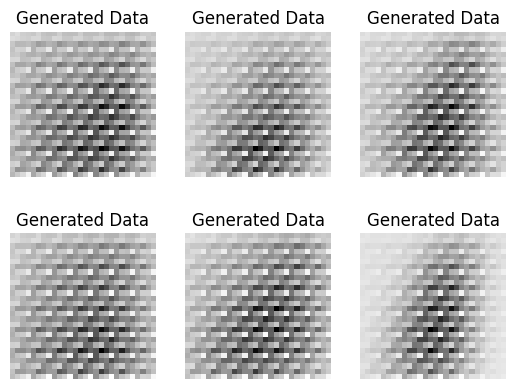

Epoch 0 - Generator Loss: 1.9933010339736938, Discriminator Loss: 0.14506669342517853, Discriminator Accuracy: 0.9715909361839294
epoch 1


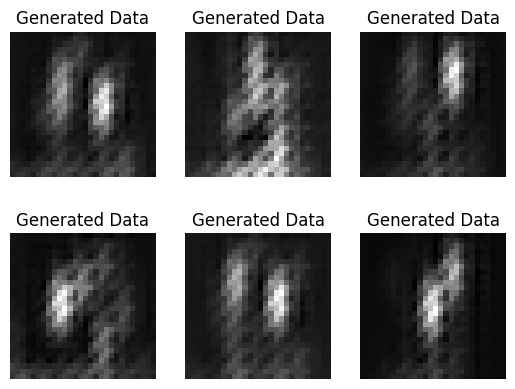

Epoch 1 - Generator Loss: 2.549781560897827, Discriminator Loss: 0.18932628631591797, Discriminator Accuracy: 0.9545454382896423
epoch 2


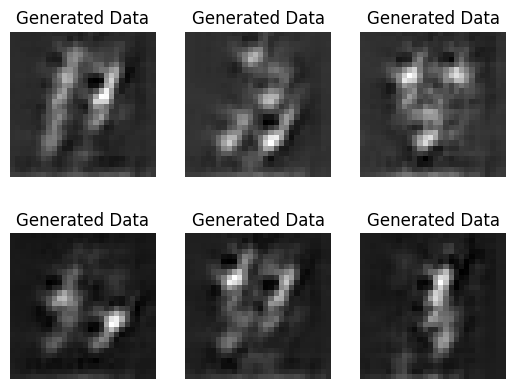

Epoch 2 - Generator Loss: 2.072469472885132, Discriminator Loss: 0.2783282995223999, Discriminator Accuracy: 0.8806818127632141
epoch 3


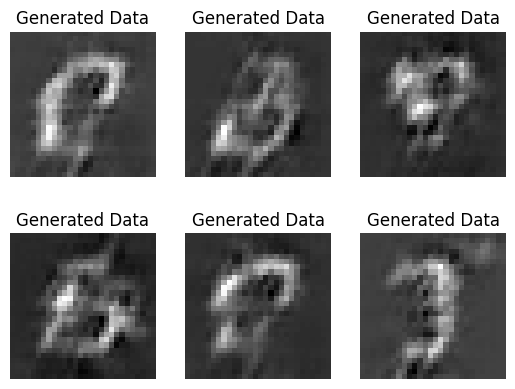

Epoch 3 - Generator Loss: 2.0673835277557373, Discriminator Loss: 0.22277411818504333, Discriminator Accuracy: 0.9261363744735718
epoch 4


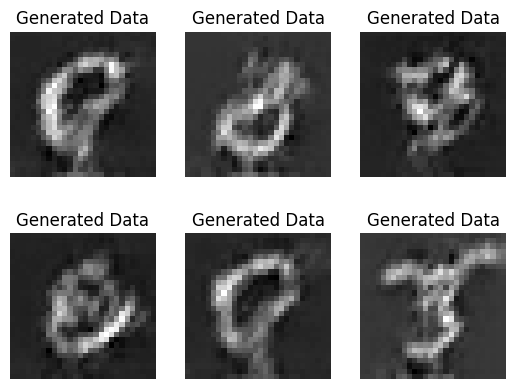

Epoch 4 - Generator Loss: 2.518930196762085, Discriminator Loss: 0.21777784824371338, Discriminator Accuracy: 0.9261363744735718
epoch 5


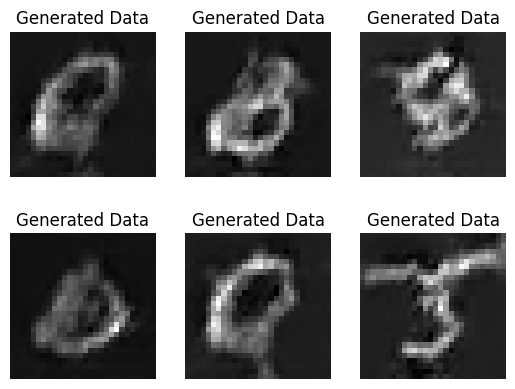

Epoch 5 - Generator Loss: 2.3809518814086914, Discriminator Loss: 0.23262915015220642, Discriminator Accuracy: 0.9261363744735718
epoch 6


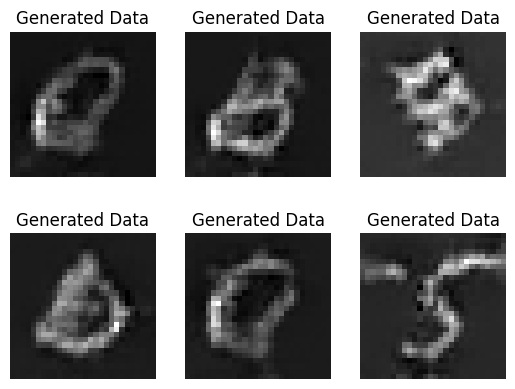

Epoch 6 - Generator Loss: 2.149757146835327, Discriminator Loss: 0.21599969267845154, Discriminator Accuracy: 0.9261363744735718
epoch 7


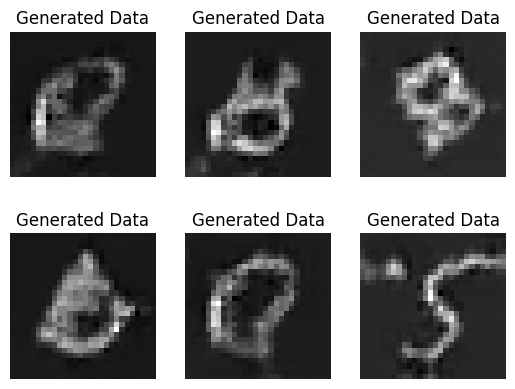

Epoch 7 - Generator Loss: 2.3447999954223633, Discriminator Loss: 0.177608460187912, Discriminator Accuracy: 0.9375
epoch 8


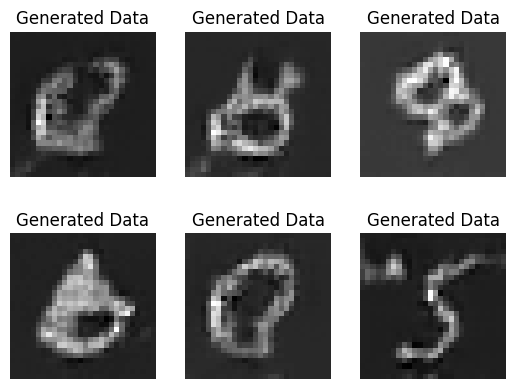

Epoch 8 - Generator Loss: 2.184997320175171, Discriminator Loss: 0.2815784215927124, Discriminator Accuracy: 0.8977272510528564
epoch 9


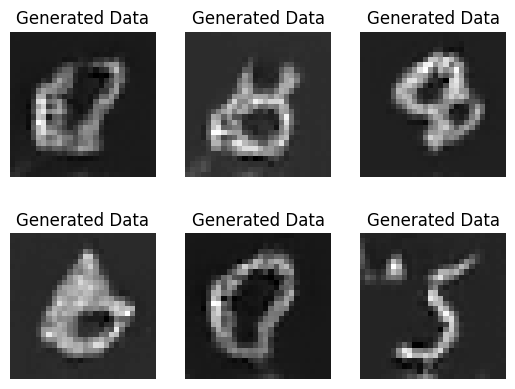

Epoch 9 - Generator Loss: 2.287144422531128, Discriminator Loss: 0.3011840581893921, Discriminator Accuracy: 0.875
epoch 10


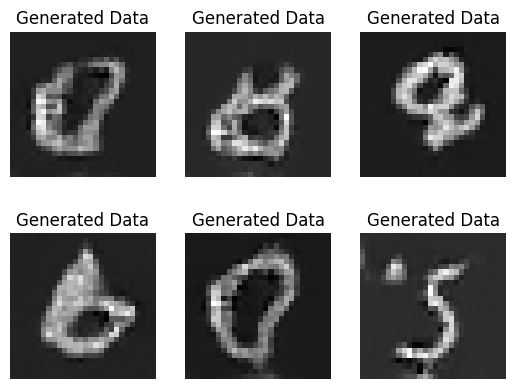

Epoch 10 - Generator Loss: 2.24638295173645, Discriminator Loss: 0.26102328300476074, Discriminator Accuracy: 0.8920454382896423
epoch 11


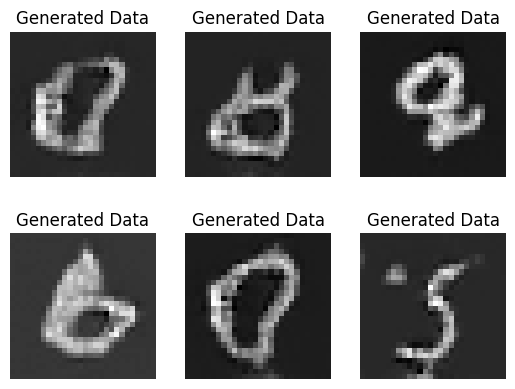

Epoch 11 - Generator Loss: 2.3957343101501465, Discriminator Loss: 0.2626616656780243, Discriminator Accuracy: 0.8863636255264282
epoch 12


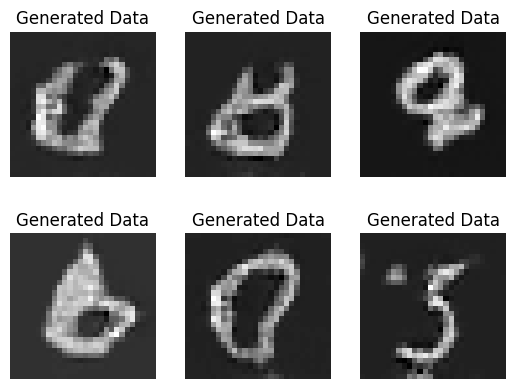

Epoch 12 - Generator Loss: 2.293555974960327, Discriminator Loss: 0.26550325751304626, Discriminator Accuracy: 0.8863636255264282
epoch 13


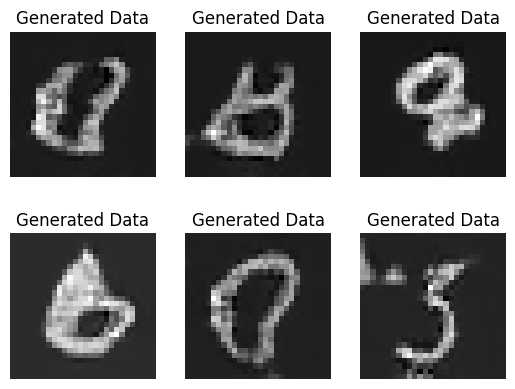

Epoch 13 - Generator Loss: 2.1381328105926514, Discriminator Loss: 0.36865097284317017, Discriminator Accuracy: 0.8636363744735718
epoch 14


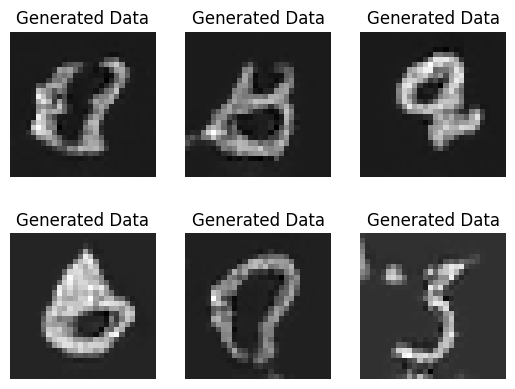

Epoch 14 - Generator Loss: 1.9870654344558716, Discriminator Loss: 0.2507377862930298, Discriminator Accuracy: 0.9090909361839294
epoch 15


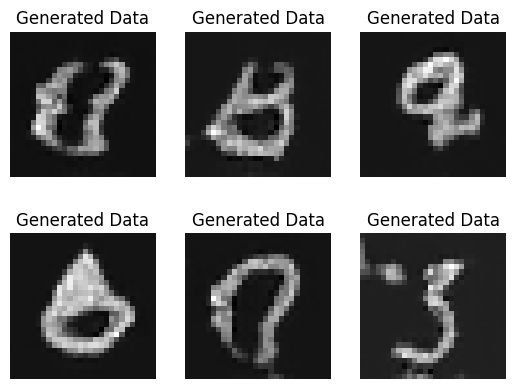

Epoch 15 - Generator Loss: 1.827682614326477, Discriminator Loss: 0.4505458176136017, Discriminator Accuracy: 0.8238636255264282
epoch 16


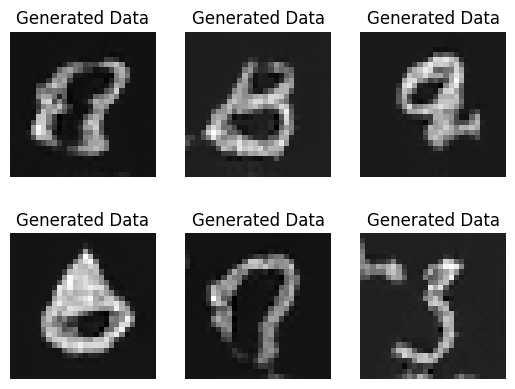

Epoch 16 - Generator Loss: 1.8574711084365845, Discriminator Loss: 0.4080553352832794, Discriminator Accuracy: 0.8238636255264282
epoch 17


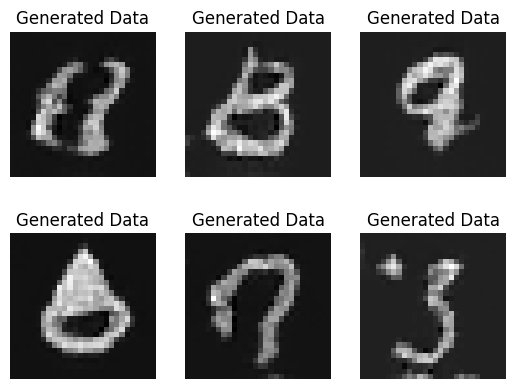

Epoch 17 - Generator Loss: 1.951429009437561, Discriminator Loss: 0.32853007316589355, Discriminator Accuracy: 0.8920454382896423
epoch 18


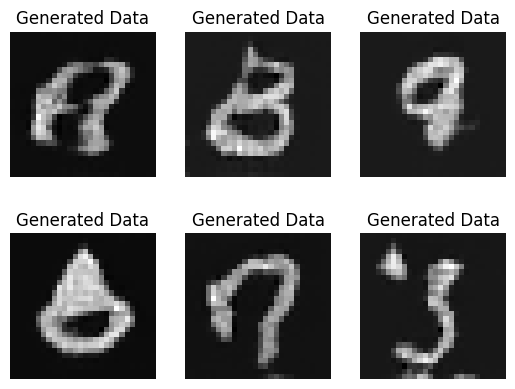

Epoch 18 - Generator Loss: 2.165306806564331, Discriminator Loss: 0.4727422595024109, Discriminator Accuracy: 0.7784090638160706
epoch 19


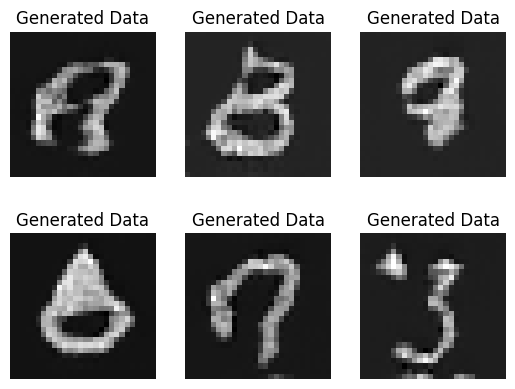

Epoch 19 - Generator Loss: 1.5649224519729614, Discriminator Loss: 0.4027179181575775, Discriminator Accuracy: 0.8181818127632141


In [ ]:
dm = MNISTDataModule()
model = GAN()

AVAIL_GPUS = 1 if torch.cuda.is_available() else 0

trainer = pl.Trainer(max_epochs=20, gpus=AVAIL_GPUS)
trainer.fit(model, dm)